In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
dimension_33d = pd.read_csv('../input_data/RelDim_labels/dimensions_33d.csv',index_col=0)
dimension_33d = dimension_33d.iloc[:,0].to_list() 

relationships = pd.read_csv('../input_data/RelDim_labels/159relationships_fix_label.csv',index_col=0)
relationships = relationships.iloc[:,0].to_list()

# Clean and combine data

In [4]:
# version1
raw_v1 = pd.read_csv('../input_data/Nations/US/SR_US1_Mturk.csv',encoding='UTF-8')
raw_v1_reorg = raw_v1.drop(axis='index',index=[0,1])
raw_v1_reorg['subject'] = list(raw_v1_reorg.index)
raw_v1_reorg = raw_v1_reorg.reset_index(drop=True)
raw_v1_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v1_reorg['Duration (in seconds)'])

response_v1 = raw_v1_reorg
response_v1['subject'] = list(raw_v1_reorg.index)
response_v1 = response_v1.loc[:, response_v1.columns.str.startswith('Q')]

# version2
raw_v2 = pd.read_csv('../input_data/Nations/US/SR_US2_Mturk.csv',encoding='UTF-8')
raw_v2_reorg = raw_v2.drop(axis='index',index=[0,1])
raw_v2_reorg['subject'] = list(raw_v2_reorg.index)
raw_v2_reorg = raw_v2_reorg.reset_index(drop=True)
raw_v2_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v2_reorg['Duration (in seconds)'])

response_v2 = raw_v2_reorg
response_v2['subject'] = list(raw_v2_reorg.index)
response_v2 = response_v2.loc[:, response_v2.columns.str.startswith('Q')]

# version3
raw_v3 = pd.read_csv('../input_data/Nations/US/SR_US3_Mturk_220627.csv',encoding='UTF-8')
raw_v3_reorg = raw_v3.drop(axis='index',index=[0,1])
raw_v3_reorg['subject'] = list(raw_v3_reorg.index)
raw_v3_reorg = raw_v3_reorg.reset_index(drop=True)
raw_v3_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v3_reorg['Duration (in seconds)'])

response_v3 = raw_v3_reorg
response_v3['subject'] = list(raw_v3_reorg.index)
response_v3 = response_v3.loc[:, response_v3.columns.str.startswith('Q')]

# combine all versions
raw_reorg_qualtrics = pd.concat([raw_v1_reorg,raw_v2_reorg,raw_v3_reorg])
responses_qualtrics = pd.concat([response_v1,response_v2,response_v3])
responses_qualtrics = responses_qualtrics.reset_index(drop=True)
# Get total number of response
print("Total number of response from qualtrics - "+str(len(responses_qualtrics)))

#####################################################################################
# Check rel foils to exclude people
filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith(('Q39','Q40'))]
foil_items = raw_v1[filtered_cols].iloc[0]
foil_items = [s.replace(' 鈥?', '-') for s in foil_items]
foil_items = [i.split(' - ', 1)[1] for i in foil_items]
foil_items = [i.replace('Victim-Criminal','Victim and Criminal') for i in foil_items]
foil_items = [i.replace('Driver - Passenger','Driver and Passenger') for i in foil_items]
foil_items = [i.replace('Parent-Infant','Parent and Infant') for i in foil_items]

foils_rel_size = pd.DataFrame(responses_qualtrics[filtered_cols])
foils_rel_size.columns = foil_items
foils_rel_size = foils_rel_size.reset_index(drop = True) # after combing all versions, reset index
foils_rel_size = foils_rel_size.apply(pd.to_numeric)

foils_rel_size_new = pd.DataFrame(columns = foils_rel_size.columns.unique())
for col in foils_rel_size.columns.unique().to_list():
    foils_list = []
    foils_df = foils_rel_size[col]
    for i in foils_df.index.to_list():
        foils = foils_df.loc[i,:].dropna().values[0]
        foils_list.append(foils)
    foils_rel_size_new[col] = foils_list
foils_rel_size = foils_rel_size_new

filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith(('Q0'))]
familiarity = pd.DataFrame(raw_reorg_qualtrics[filtered_cols])
familiarity.columns = relationships
familiarity = familiarity.reset_index(drop = True) # after combing all versions, reset index
#familiarity['subject'] = raw_reorg_qualtrics['subject']
familiarity = familiarity.apply(pd.to_numeric)

#dim_comprehension
count = 4
filtered_dim_com = []
while count <= 38:
    [filtered_dim_com.append(col) for col in raw_reorg_qualtrics if col.startswith('Q'+str(count)+'.1')]
    if count == 33 or count == 36:
        count += 2
    else:
        count += 1
response_dim_com = responses_qualtrics[filtered_dim_com]
                     
dimension_frames = {}
count=4
for dim in dimension_33d: 
    if count == 34 or count == 37:
        count = count + 1
    filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith('Q'+str(count)+'.2')]
    dimension_frames[dim] = pd.DataFrame(responses_qualtrics[filtered_cols])
    dimension_frames[dim].columns = relationships
    count=count+1
    
# foils_rel_size_qualtrics = foils_rel_size
# familiarity_qualtrics = familiarity
# response_dim_com_qualtrics = response_dim_com

Total number of response from qualtrics - 629


<AxesSubplot: xlabel='variable', ylabel='value'>

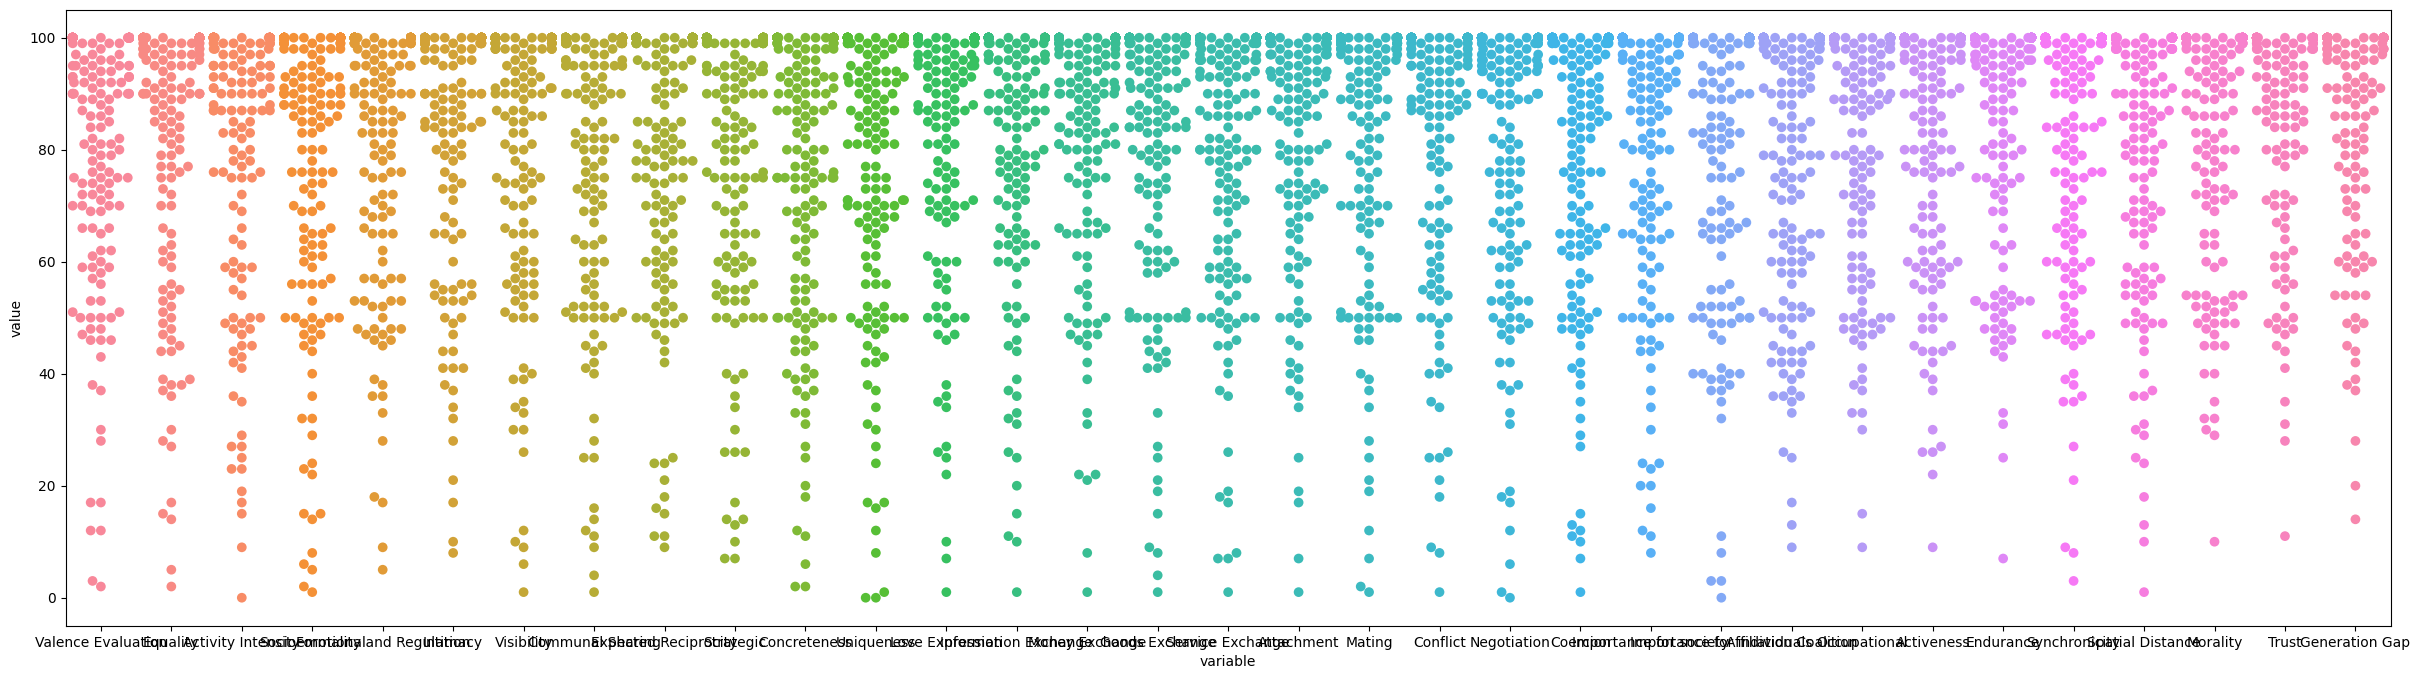

In [5]:
# comprehension of dimensions
dim_com_df_v1 = pd.DataFrame(columns=dimension_33d[0:11])
dim_com_df_v2 = pd.DataFrame(columns=dimension_33d[11:22])
dim_com_df_v3 = pd.DataFrame(columns=dimension_33d[22:33])

# due to the different sample in different version, separate conditon to extract items
count = 4
for dim in dimension_33d:
    filiter_dim = [col for col in response_dim_com.columns if (col.startswith('Q'+str(count)))]
    if count == 33 or count == 36:
        count += 2
    else:
        count +=1
    temp_df = response_dim_com[filiter_dim]
    temp_df = temp_df.dropna(how='all')
    
    dim_list_v1 = []
    dim_list_v2 = []
    dim_list_v3 = []
    if count <= 15:
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v1.append(value)
        dim_com_df_v1[dim] = dim_list_v1
        
    if (count > 15) & (count <= 26):
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v2.append(value)
        dim_com_df_v2[dim] = dim_list_v2
        
    if count > 26:
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v3.append(value)
        dim_com_df_v3[dim] = dim_list_v3

# transform wide into long format
dim_com_df_v1_melt = pd.melt(dim_com_df_v1)
dim_com_df_v2_melt = pd.melt(dim_com_df_v2)
dim_com_df_v3_melt = pd.melt(dim_com_df_v3)
dim_com_df_melt = pd.concat([dim_com_df_v1_melt,dim_com_df_v2_melt,dim_com_df_v3_melt],axis=0)
dim_com_df_melt['value'] = dim_com_df_melt['value'].apply(pd.to_numeric)

plt.figure(figsize=(30,8))
sns.swarmplot(data=dim_com_df_melt,x='variable',y='value',size=7)

# Filter and form dictionary

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total number of responses, excluding bad participants - 567
Smallest number of ratings for a relationship - 5
Largest number of ratings for a relationship - 15


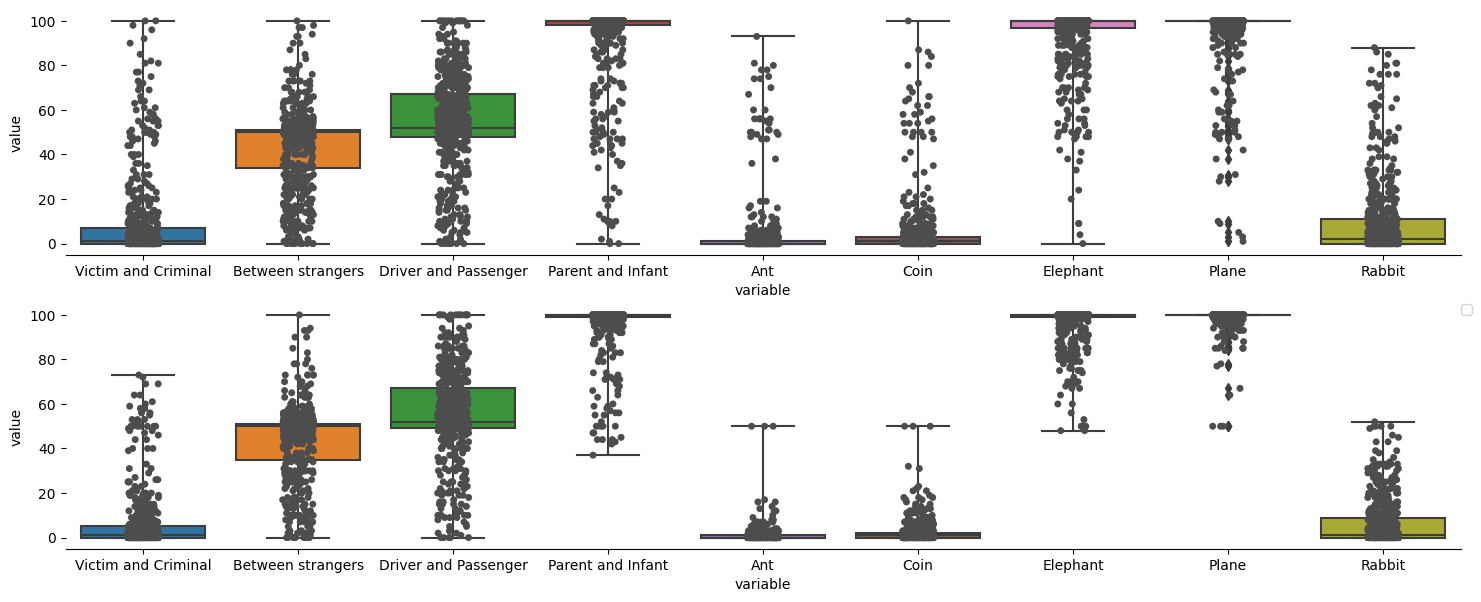

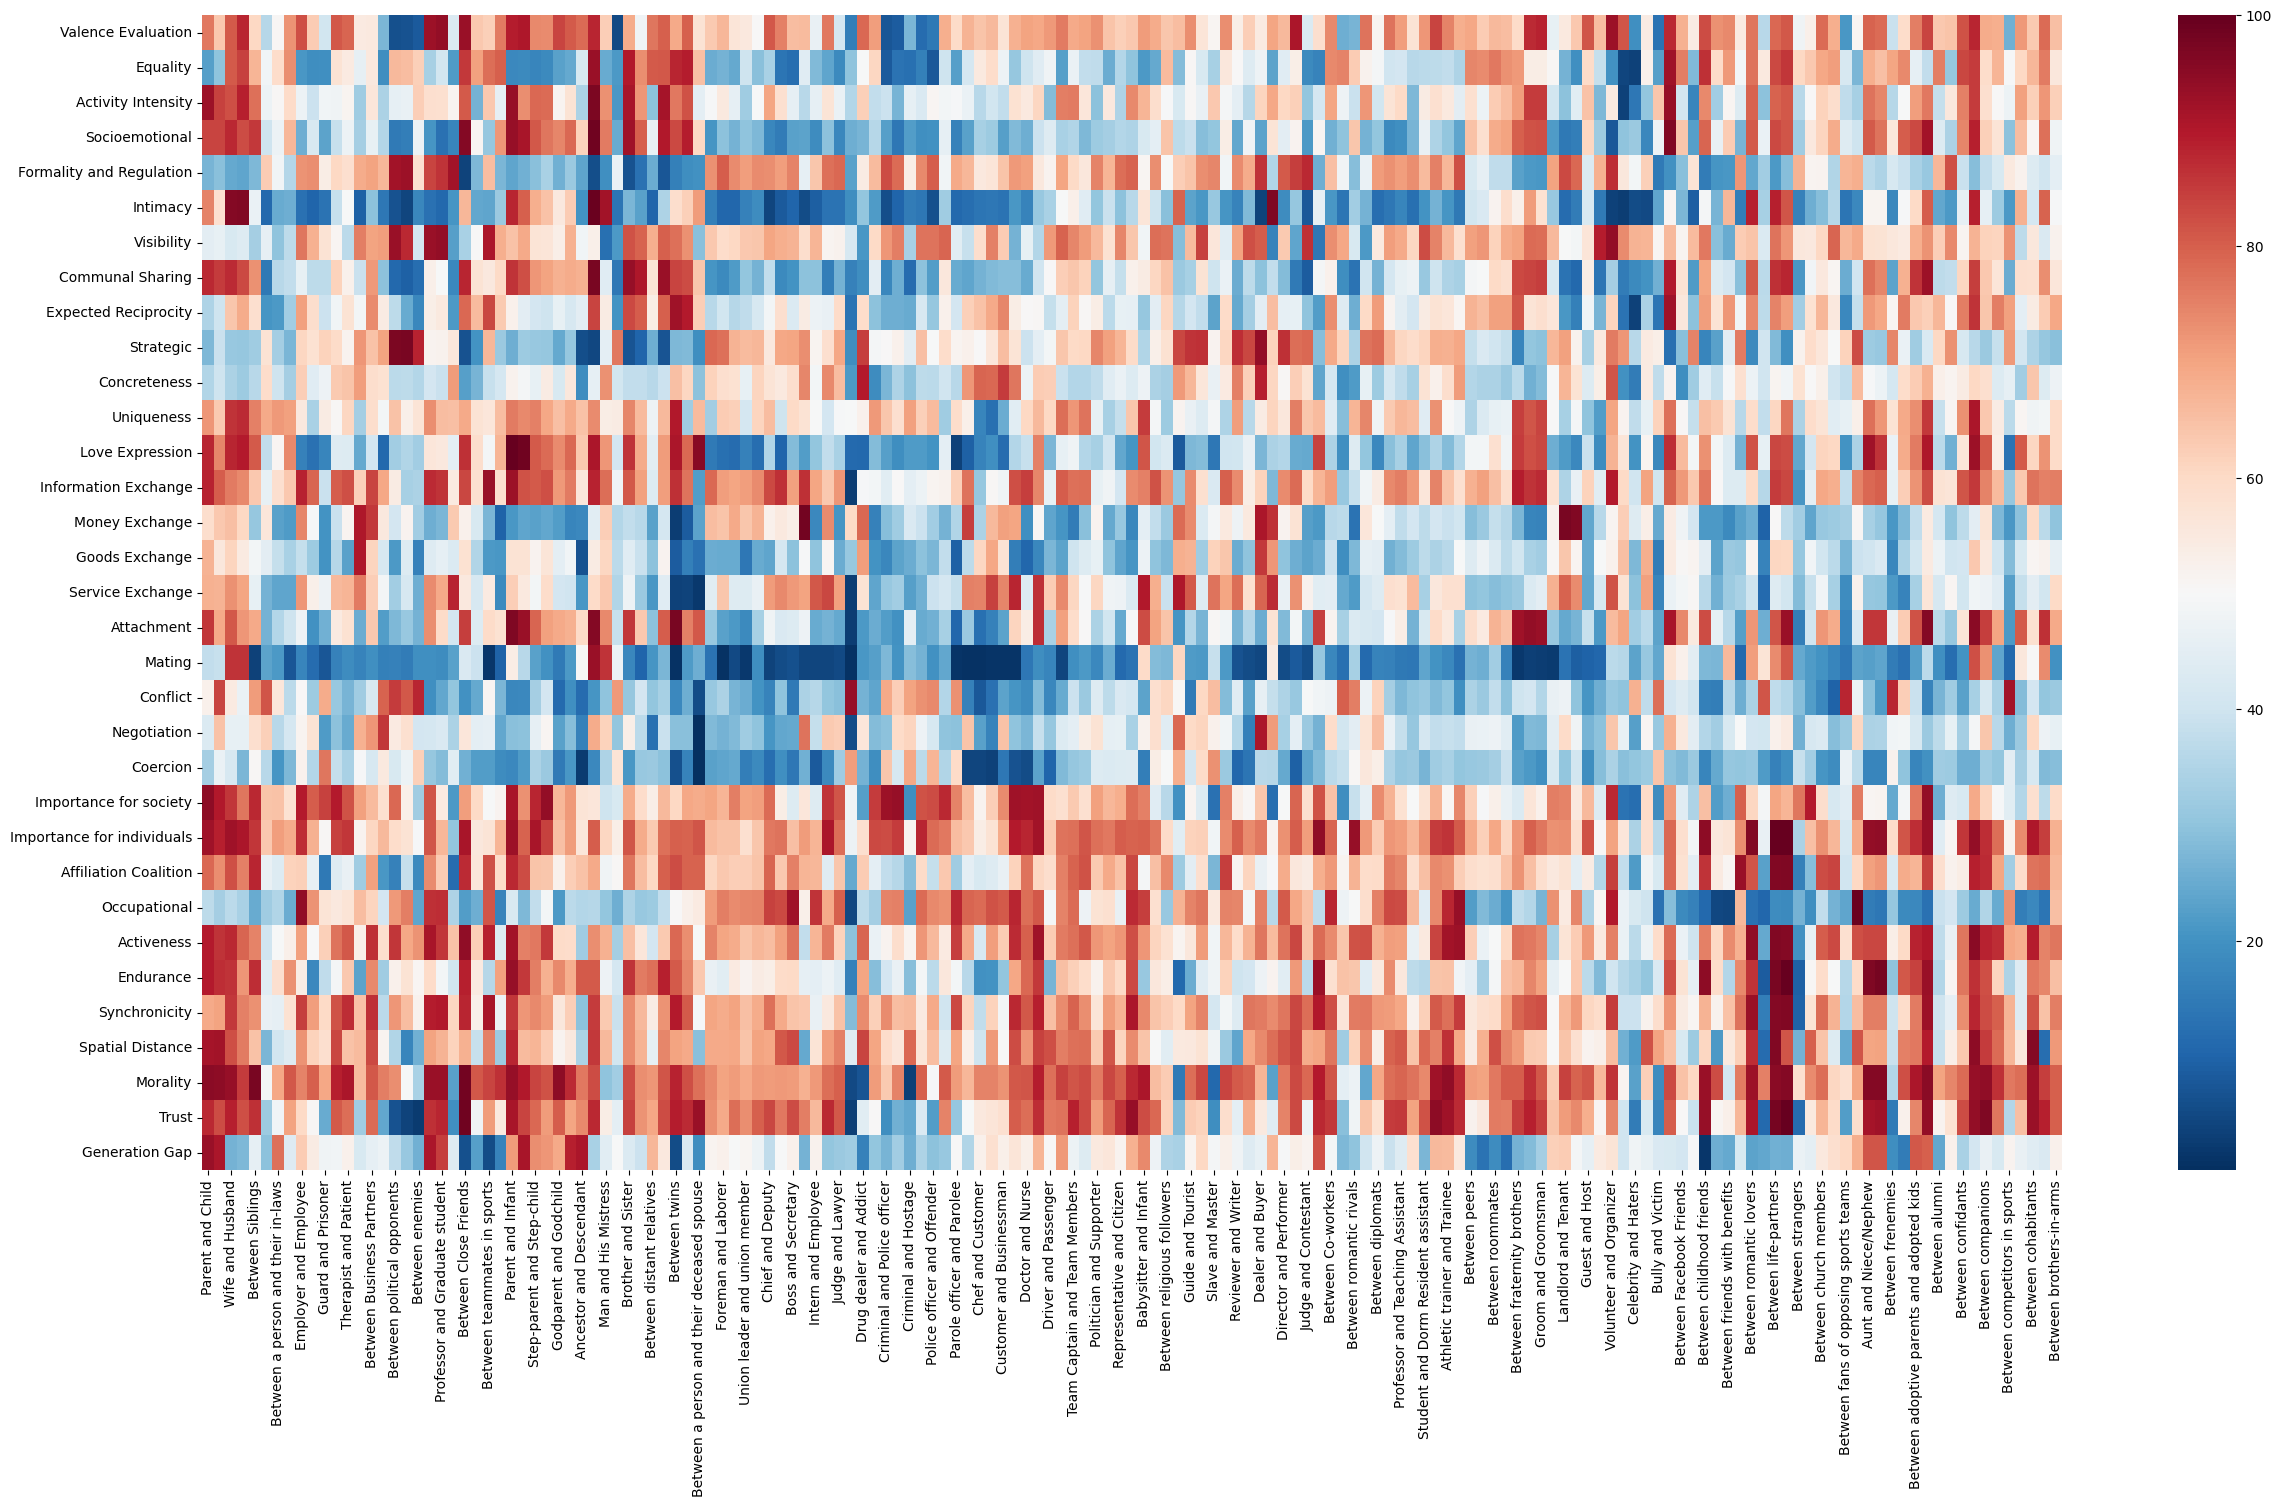

In [6]:
std = 3.5
foils_rel_size['subject'] = foils_rel_size.index.to_list()
foils_rel_size = foils_rel_size.apply(pd.to_numeric)
foils_rel_size_melt = pd.melt(foils_rel_size, id_vars='subject')
foils_rel_size_melt.columns = ['subject','variable','value']
outliers_rel_size_list = []
for col in foils_rel_size.columns[:-1]:
    outliers_rel_size_list = outliers_rel_size_list + list(foils_rel_size[(foils_rel_size[col] > 
                   foils_rel_size[col].mean()+foils_rel_size[col].std()*std) |
                   (foils_rel_size[col] < 
                    foils_rel_size[col].mean()-foils_rel_size[col].std()*std)].index)
outliers_rel_size_list = set(outliers_rel_size_list)

foil_rel_size_outliers = foils_rel_size
foil_rel_size_outliers = foil_rel_size_outliers[~foil_rel_size_outliers.index.isin(outliers_rel_size_list)]
foil_rel_size_outliers_melt = pd.melt(foil_rel_size_outliers, id_vars='subject')
foil_rel_size_outliers_melt.columns = ['subject','variable','value']

f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_rel_size_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_rel_size_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_rel_size_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_rel_size_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)


#check familiarity
familiarity['subject'] = familiarity.index.to_list()
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='subject')

#Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] > 
                   familiarity[col].mean()+familiarity[col].std()*3.5) |
                   (familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

#remove outliers from original data
outliers_all_list = set(list(outliers_rel_size_list) + list(familiarity_list))
outliers_all_list_df = pd.DataFrame(outliers_all_list)
outliers_all_list_df.to_csv('../output_data/outlier_df/USA.csv')

dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

#Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimension_33d)
for dim in dimension_33d:
    num_response_outliers[dim] = dimension_frames_outliers[dim].count() 
#

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))


result_dict = dimension_frames_outliers
dim_rel = pd.DataFrame(columns=relationships)
count=0
col_names = []
for dim in result_dict.keys():
    dim_rel.loc[count] = result_dict[dim].mean().tolist()
    col_names.append(dim)
    count = count + 1
dim_rel.index = result_dict.keys()
dim_rel.to_csv('../output_data/cleaning_results/USA/USA_dim_rel.csv')
dim_rel.iloc[0:30,:].to_csv('../output_data/cleaning_results/USA/USA_dim_rel_30d.csv')

plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('../output_data/cleaning_results/USA/USA_dim_rel_scaled.csv')
dim_rel_scaled_df.iloc[:,0:30].to_csv('../output_data/cleaning_results/USA/USA_dim_rel_scaled_30d.csv')

# Demographic

In [7]:
outlier_df = pd.read_csv('../output_data/outlier_df/USA.csv',index_col=0)
outlier_df_list = outlier_df.iloc[:,0].to_list()
foils_rel_size = foils_rel_size.reset_index(drop=True)
foils_rel_size_outliers = foils_rel_size[~foils_rel_size.index.isin(outlier_df_list)]
foils_rel_size_outliers.to_csv('../output_data/foils_rel_size/USA.csv')
familiarity = familiarity.reset_index(drop=True)
familiarity_outliers = familiarity[~familiarity.index.isin(outlier_df_list)]
familiarity_outliers.to_csv('../output_data/familiarity/USA.csv')

response_demographic = responses_qualtrics.loc[:,responses_qualtrics.columns.str.startswith('Q41')]
response_demographic = response_demographic.reset_index(drop=True)
response_demographic = response_demographic[~response_demographic.index.isin(outlier_df_list)]
response_demographic = response_demographic.iloc[:,1:]

response_demographic.columns = ['Age','Gender','Race','Race_alternative',
                                'Highest education','First language']

## Gender

In [8]:
response_demographic['Gender'].value_counts()

Female    431
Male      136
Name: Gender, dtype: int64

## Age

In [9]:
age = response_demographic['Age']
age = age.apply(int)

age_df = pd.DataFrame(columns = ['age','count'])
age_df['age'] = range(1,121)
count_df = []
for i in range(1,121):
    count = 0
    for j in age:
        if i == j:
            count = count + 1
    count_df.append(count)
age_df['count'] = count_df
age_df.to_csv('../output_data/demographic/USA/age_df.csv')

## Race

In [10]:
response_demographic['Race'].value_counts()

White                                  434
Black                                   56
Other (write in)                        44
East Asian Chinese, Japanese, etc.      18
South Asian Indian, Pakistani, etc.      9
Arabic, Central Asian                    6
Name: Race, dtype: int64

## Highest education

In [11]:
response_demographic['Highest education'].value_counts()

Bachelor or equivalent                   229
Upper secondary education                 79
Master or equivalent                      74
Short-cycle tertiary education            61
Post-secondary non-tertiary education     60
Primary education                         20
Lower secondary education                 16
Don't know/No answer                      15
Doctoral or equivalent                    13
Name: Highest education, dtype: int64

## First language

In [12]:
response_demographic['First language'].value_counts()

English                                                                   365
english                                                                   106
English                                                                    46
ENGLISH                                                                    13
Spanish                                                                     6
Tagalog                                                                     5
American English                                                            3
German                                                                      3
korean                                                                      2
Bengali                                                                     2
spanish                                                                     2
Bilingual: American Sign Language (ASL) & English                           1
Bilingual: American Sign Language & English                     

# PCA with varimax rotation

In [2]:
library(tidyverse)
library(reshape)

library(psych)
#optimal number of components
library(nFactors)

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(corrplot)

In [3]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

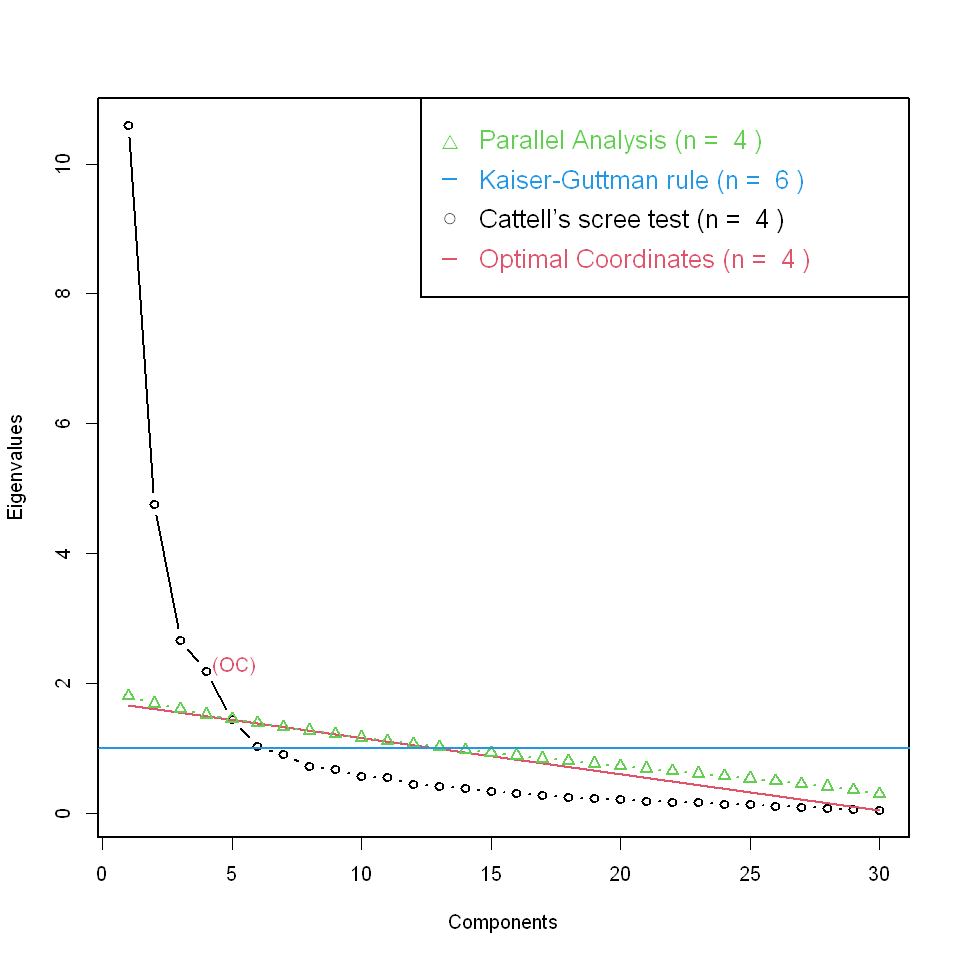

In [7]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('../output_data/cleaning_results/USA/USA_dim_rel_scaled_30d.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

plotnScree(nS,elbow = 4, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

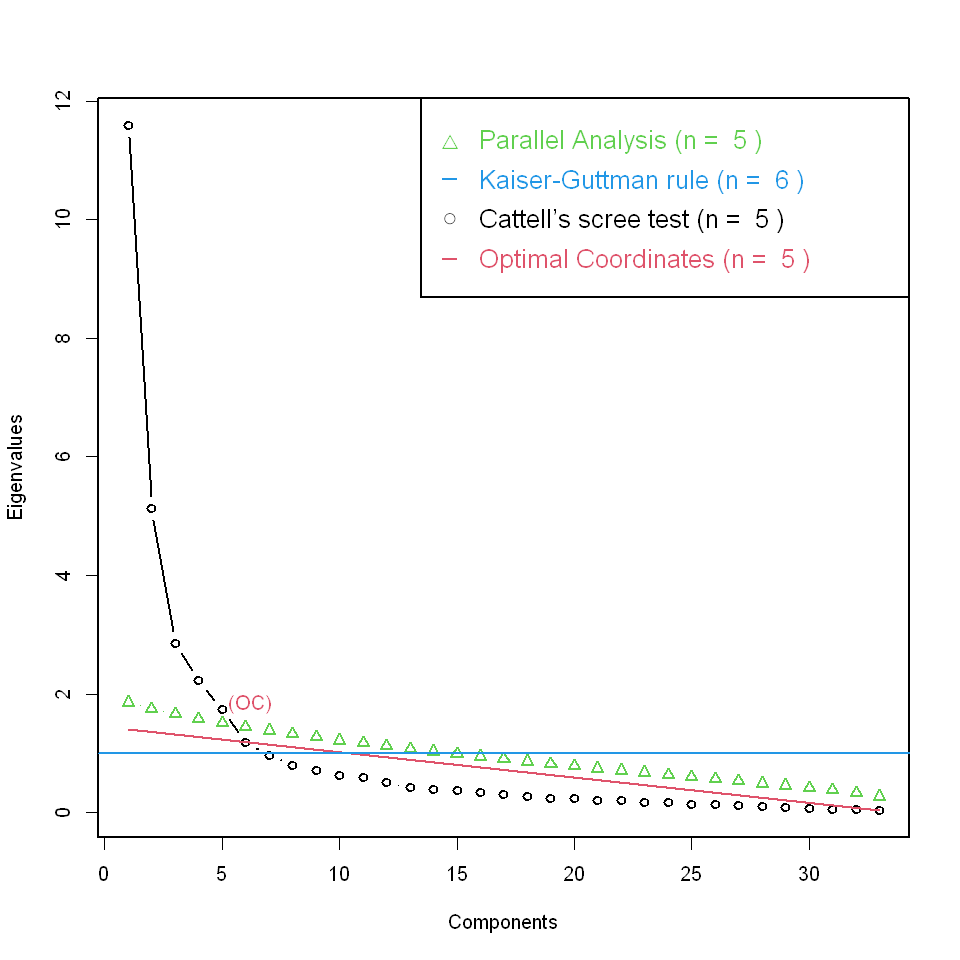

In [5]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('../output_data/cleaning_results/USA/USA_dim_rel_scaled.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

plotnScree(nS,elbow = 5, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

## 5d solution

In [5]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/USA/USA_loadings_var_5c_30d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/USA/USA_scores_var_5c_30d.csv')

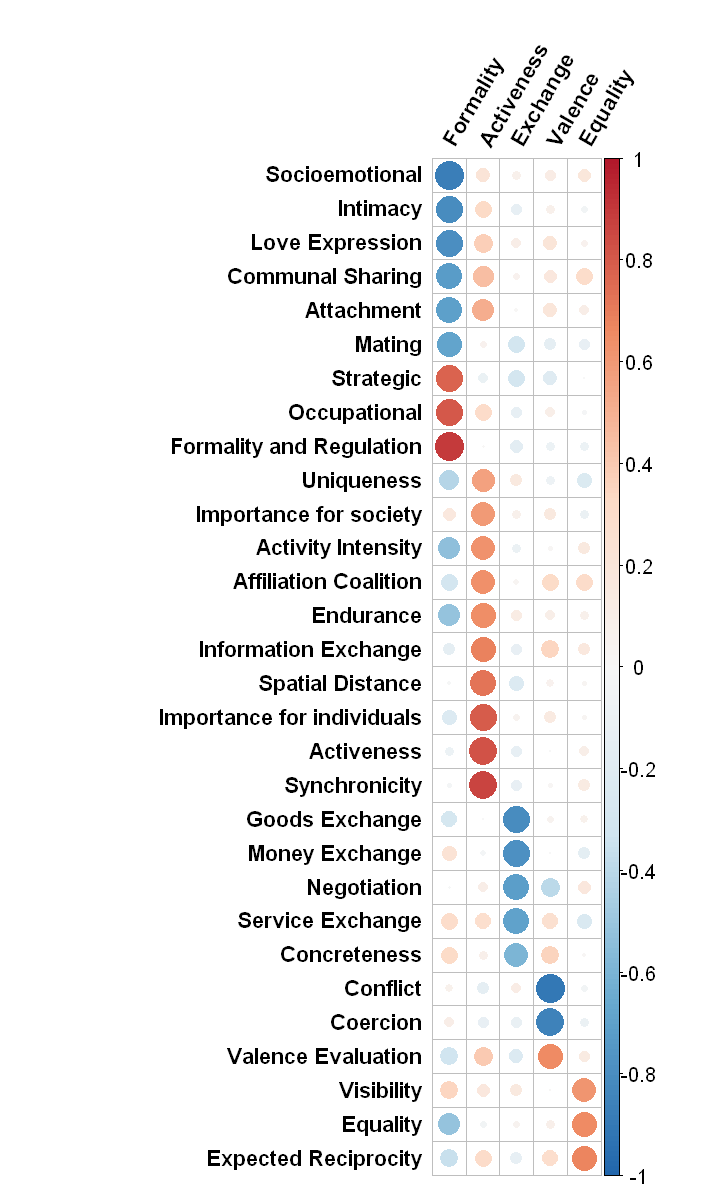

In [6]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Formality','Activeness','Exchange','Valence','Equality')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

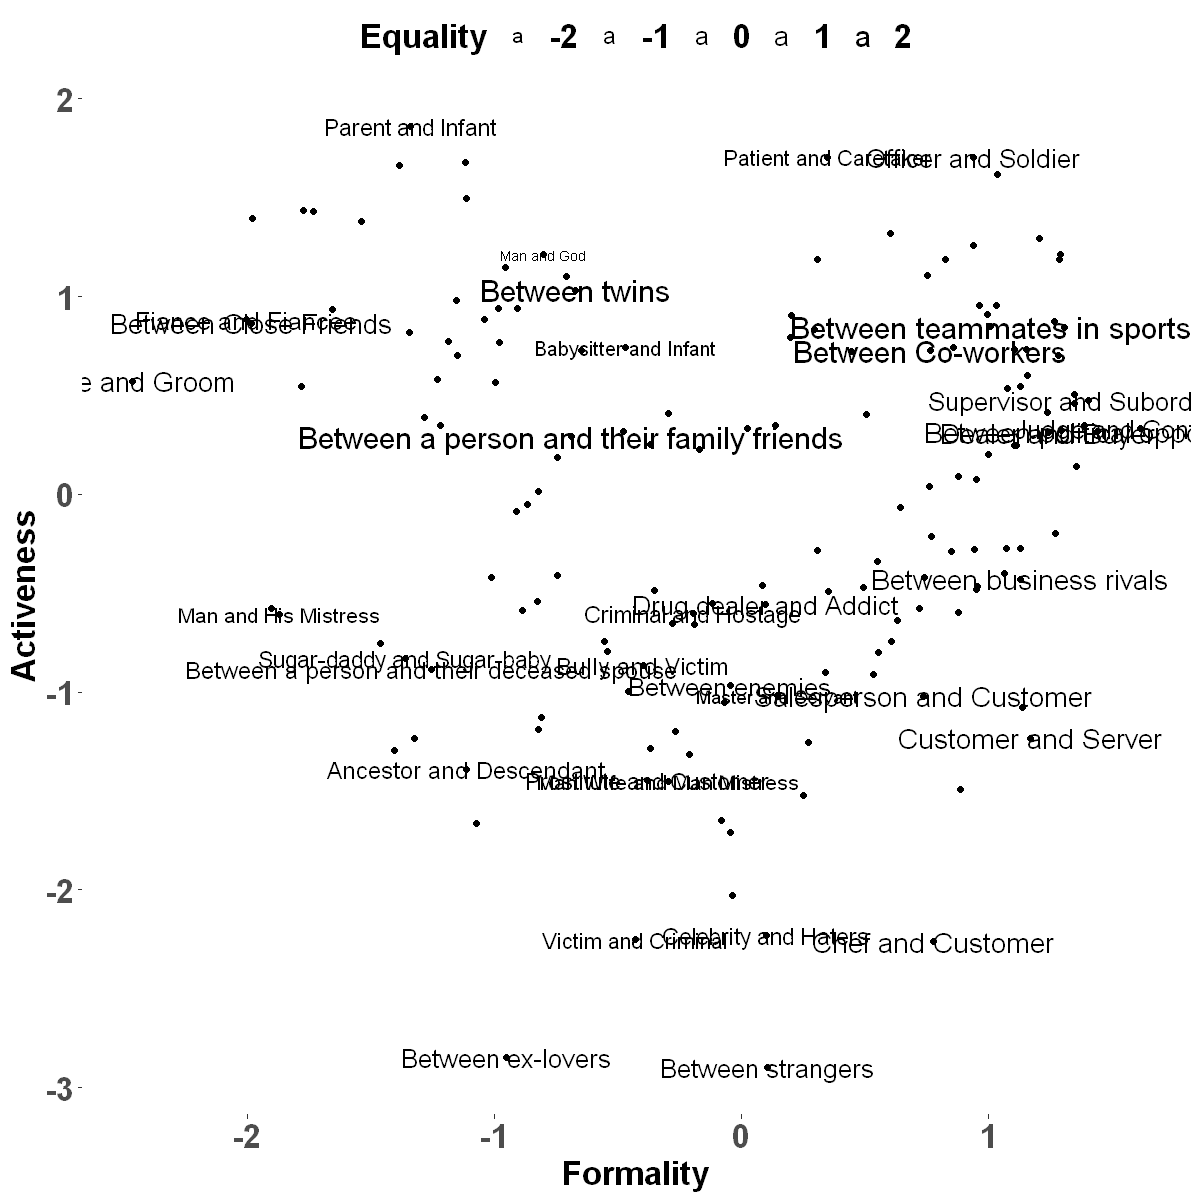

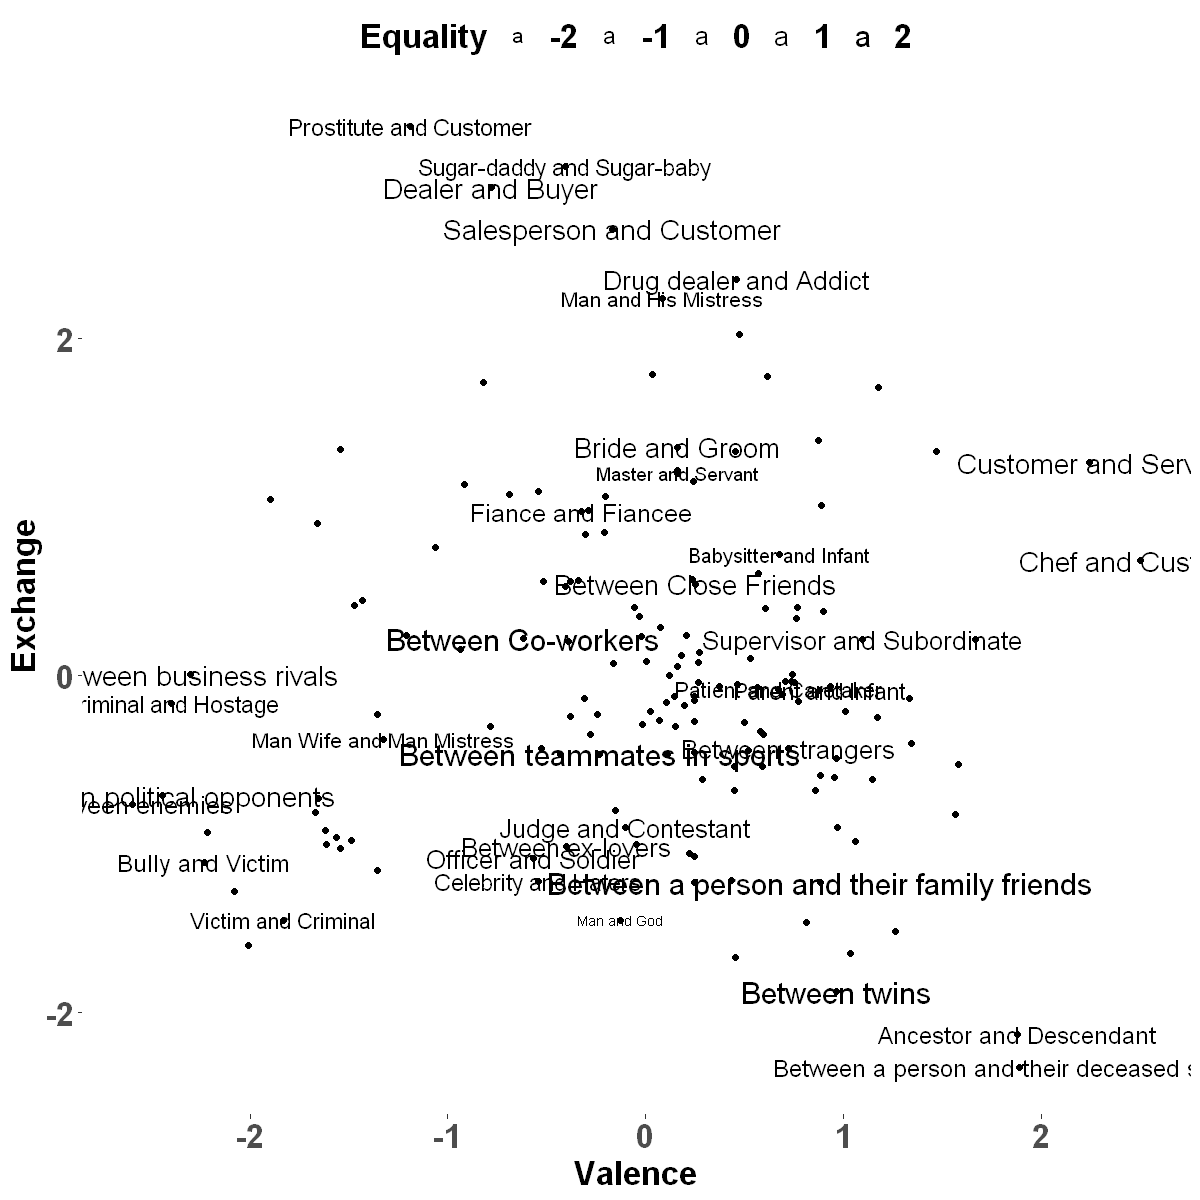

In [7]:
num = 3
show_rel = c(rownames(scores_var[order(scores_var$V1),])[1:num],
             rownames(scores_var[order(scores_var$V1),])[159-num+1:159],
             rownames(scores_var[order(scores_var$V2),])[1:5],
             rownames(scores_var[order(scores_var$V2),])[159-num+1:159],
             rownames(scores_var[order(scores_var$V3),])[1:5],
             rownames(scores_var[order(scores_var$V3),])[159-num+1:159],
             rownames(scores_var[order(scores_var$V4),])[1:5],
             rownames(scores_var[order(scores_var$V4),])[159-num+1:159],
             rownames(scores_var[order(scores_var$V5),])[1:5],
             rownames(scores_var[order(scores_var$V5),])[159-num+1:159])

scores_var_plot = scores_var
colnames(scores_var_plot) = c('Formality','Activeness','Exchange','Valence','Equality')
scores_var_plot['Exchange'] = -scores_var_plot['Exchange']

scores_var_plot['rel'] = rownames(scores_var_plot)
show_rel_df = scores_var_plot %>% filter(rel %in% show_rel)

options(repr.plot.width=10,repr.plot.height=10)
ggplot(scores_var_plot,aes(x=Formality,y=Activeness))+
geom_point()+
geom_text(data=show_rel_df,aes(label=rel,size=Equality))+
scale_size_continuous(range = c(3,6.5))+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      legend.title=element_text(face="bold",size=20),
      axis.title.x=element_text(size=20,face='bold'),
      axis.title.y=element_text(size=20,face='bold'),
      axis.text=element_text(size=20,face='bold'),
      legend.position='top',
      legend.text=element_text(face="bold",size=20))

ggplot(scores_var_plot,aes(x=Valence,y=Exchange))+
geom_point()+
geom_text(data=show_rel_df,aes(label=rel,size=Equality))+
scale_size_continuous(range = c(3,6.5))+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      legend.title=element_text(face="bold",size=20),
      axis.title.x=element_text(size=20,face='bold'),
      axis.title.y=element_text(size=20,face='bold'),
      axis.text=element_text(size=20,face='bold'),
      legend.position='top',
      legend.text=element_text(face="bold",size=20))

## 33d

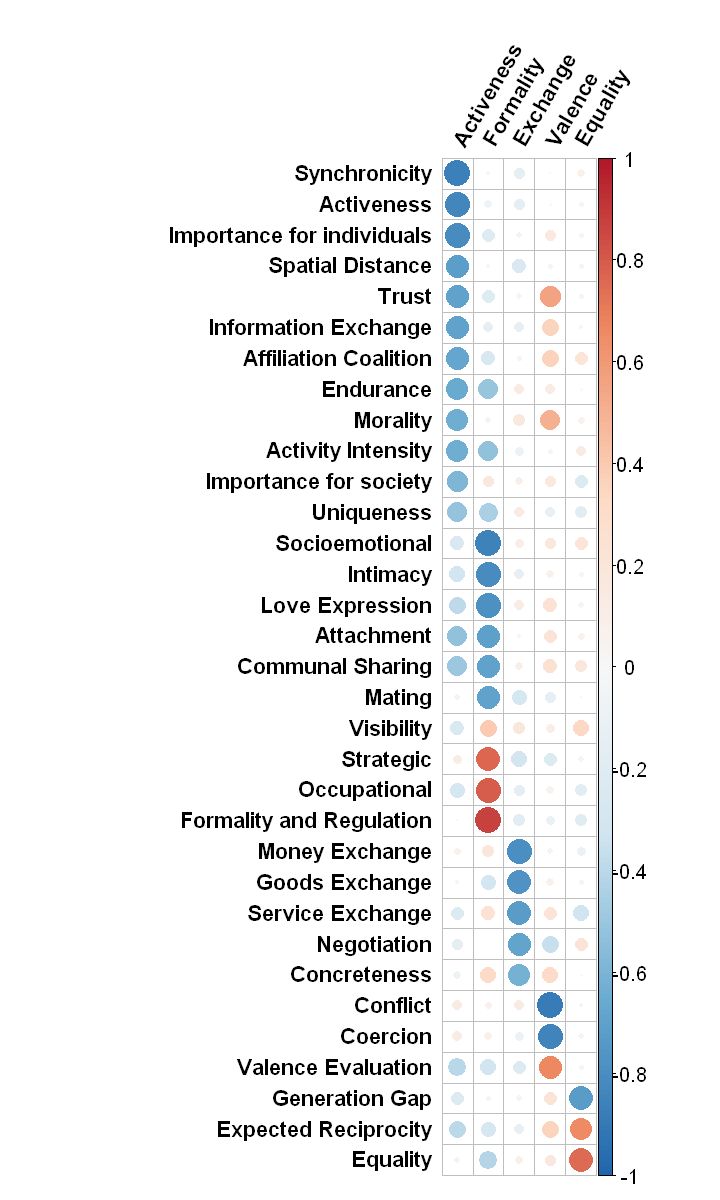

In [4]:
dim_rel_scaled_33d = read.csv('../output_data/cleaning_results/USA/USA_dim_rel_scaled.csv',
                          row.names=1,encoding='UTF-8',check.names=FALSE)

dim_rel.pca = prcomp(dim_rel_scaled_33d)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/USA/USA_loadings_var_5c_33d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/USA/USA_scores_var_5c_33d.csv')

#####################################################################################
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Activeness','Formality','Exchange','Valence','Equality')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))